## Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm

from pathlib import Path

plt.style.use("ggplot")

## Data

In [3]:
PATH_DATA = Path("../Data")

df = pd.read_csv(PATH_DATA / "h1weekly.csv", parse_dates=["Date"])

In [4]:
df

,Date,IsCanceled
0,2015-06-21,41
1,2015-06-28,48
2,2015-07-05,87
3,2015-07-12,74
4,2015-07-19,101
...,...,...
110,2017-07-30,173
111,2017-08-06,140
112,2017-08-13,182
113,2017-08-20,143


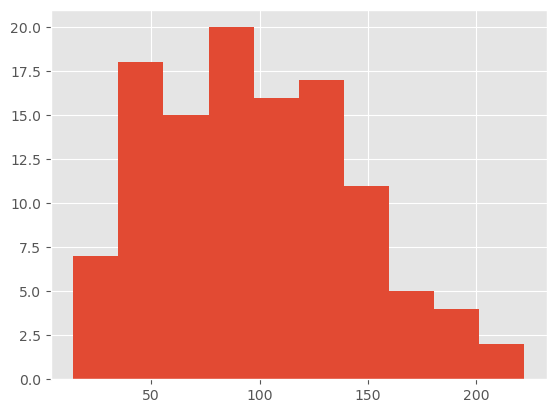

In [6]:
plt.hist(df["IsCanceled"]);

In [8]:
np.mean(df["IsCanceled"]), np.std(df["IsCanceled"])

(96.71304347826087, 45.6656592918938)

## 1.

In [11]:
mu_prior = (222+14) / 2
sigma_prior = 10
print(mu_prior, sigma_prior)

118.0 10


In [12]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=mu_prior, sigma=sigma_prior)
    sd = pm.HalfCauchy("sd", beta=10)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=df["IsCanceled"])
    idata = pm.sample(1000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [14]:
with model:
    post_pred = pm.sample_posterior_predictive(idata.posterior)

Sampling: [obs]


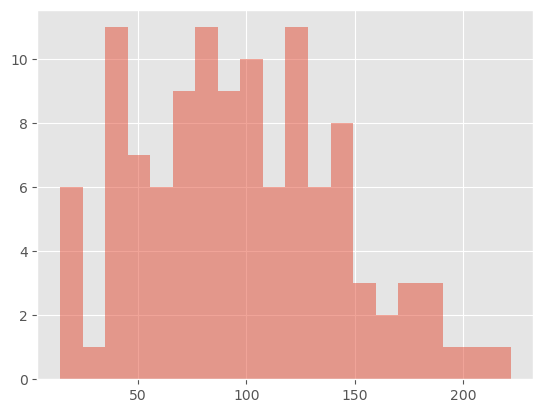

In [27]:
plt.hist(post_pred["observed_data"]["obs"], bins=20, alpha=0.5, label="Posterior predictive");

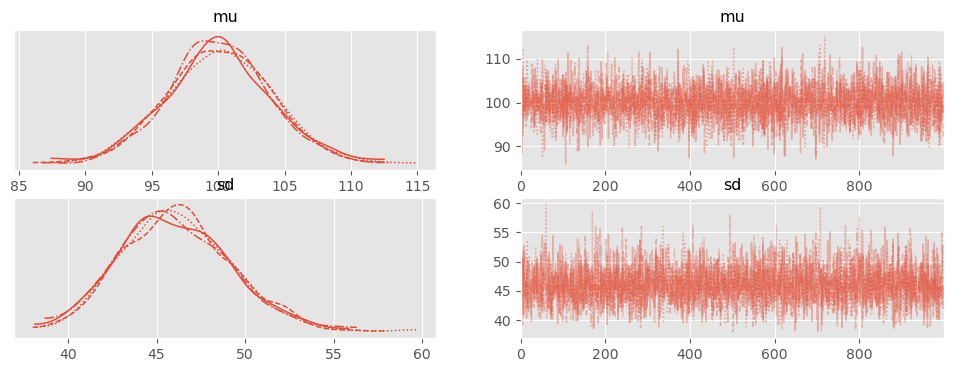

In [19]:
az.plot_trace(idata);

In [28]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,100.061,3.962,92.446,107.442,0.065,0.046,3731.0,2827.0,1.0
sd,46.095,3.134,40.541,52.254,0.051,0.036,3873.0,2606.0,1.0


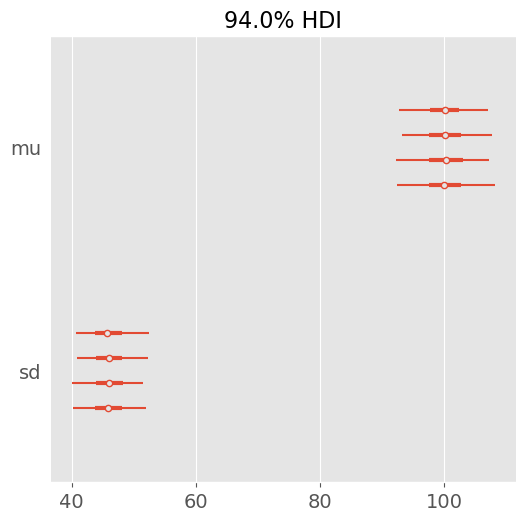

In [31]:
az.plot_forest(idata);

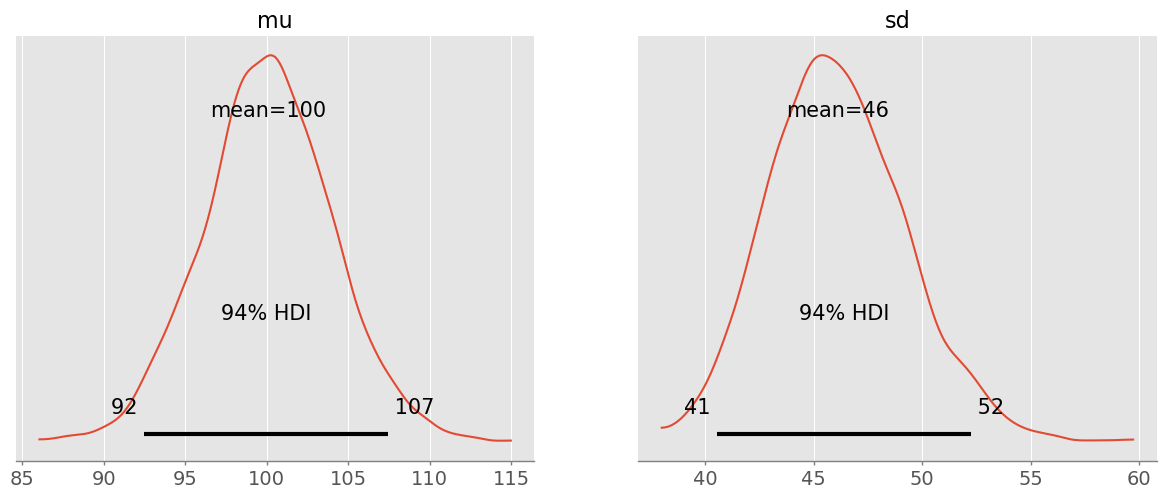

In [32]:
az.plot_posterior(idata);

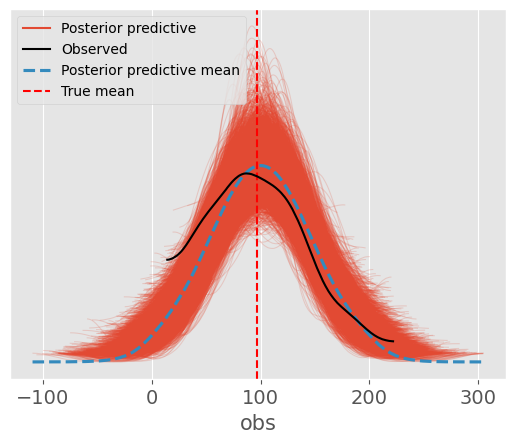

In [34]:
fig, ax = plt.subplots()
az.plot_ppc(post_pred, ax=ax)
ax.axvline(df["IsCanceled"].mean(), ls="--", color="r", label="True mean")
ax.legend(fontsize=10);

## 2.

### AR(1)

In [ ]:
# AR(1) model with 2000 samples
with pm.Model() as model_ar1:
    rho = pm.Normal("rho", mu=0, sigma=1)
    tau = pm.HalfCauchy("tau", beta=10)
    obs = pm.AR("obs", rho=rho, tau=tau, observed=df["IsCanceled"], ar_order=1, init_dist=pm.Normal.dist(mu=mu_prior, sigma=sigma_prior))
    idata_ar1 = pm.sample(2000, tune=2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, tau]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1 seconds.


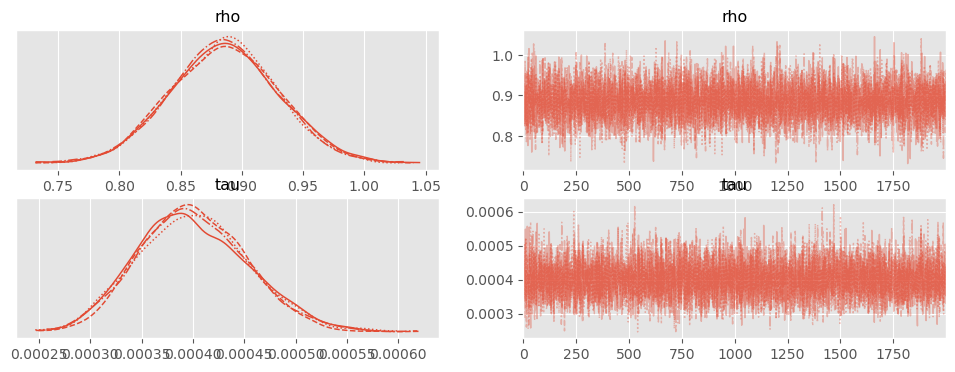

In [39]:
az.plot_trace(idata_ar1);

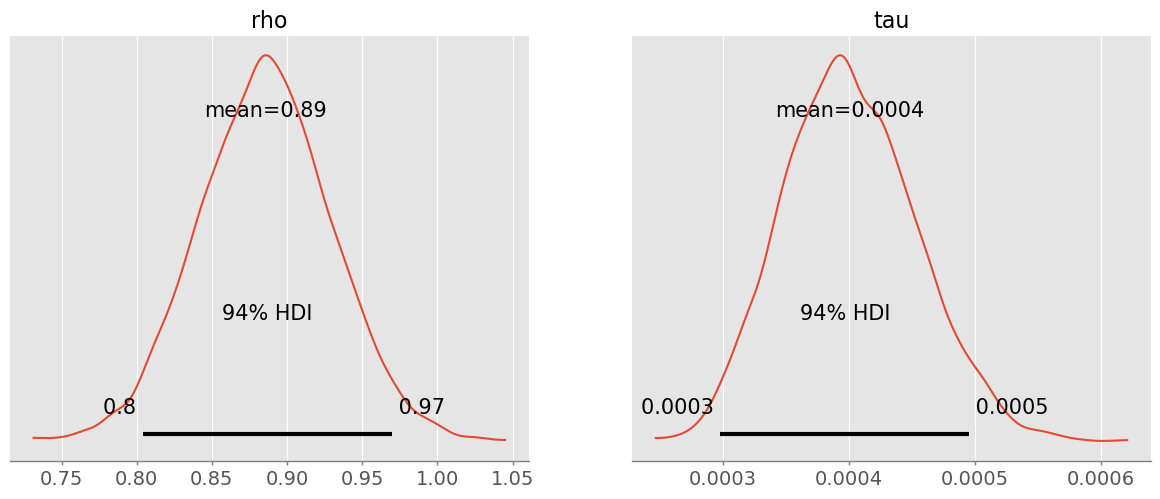

In [40]:
pm.plot_posterior(idata_ar1);

In [41]:
pm.summary(idata_ar1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rho,0.886,0.044,0.804,0.97,0.001,0.0,7225.0,5109.0,1.0
tau,0.000,0.000,0.000,0.00,0.000,0.0,7626.0,5698.0,1.0


### MA(5)

In [42]:
window_size = 5
data_ma = df["IsCanceled"].rolling(window_size).mean().dropna()
data_ma

4       70.2
5       75.6
6       85.2
7       81.6
8       84.4
       ...  
110    150.0
111    151.8
112    160.4
113    159.0
114    147.6
Name: IsCanceled, Length: 111, dtype: float64

In [46]:
with pm.Model() as model_ma:
    tau = pm.HalfCauchy("tau", beta=10)
    k = pm.Uniform("k", lower=-1, upper=1)
    ma5 = pm.AR("obs", rho=k, tau=tau, observed=data_ma, ar_order=1)
    idata_ma = pm.sample(2000, tune=2000, return_inferencedata=True)

/home/phili/miniconda3/envs/arvizok/lib/python3.10/site-packages/pymc/distributions/timeseries.py:558: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100, shape=...)`. You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, k]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.


array([<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'k'}>],
      dtype=object)

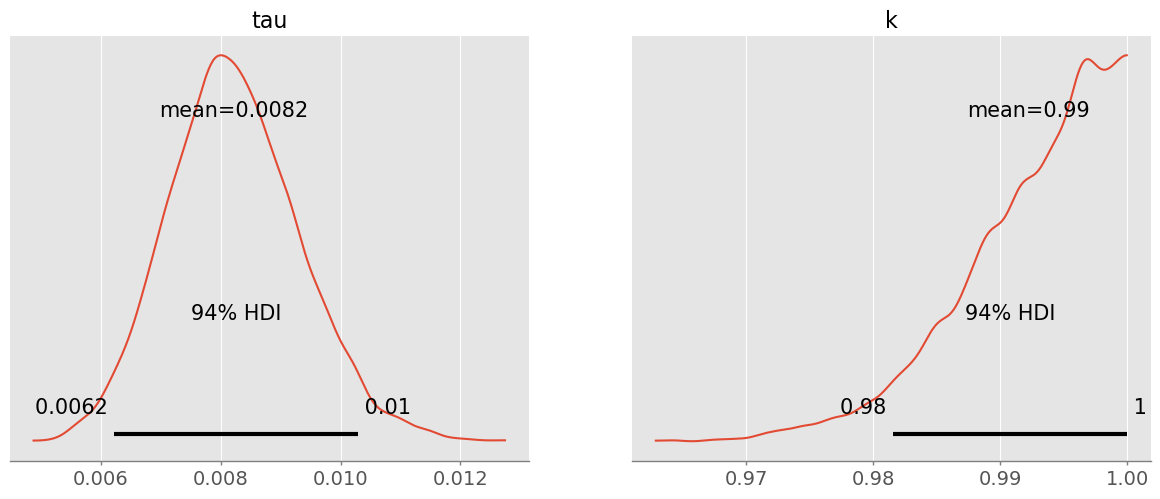

In [47]:
pm.plot_posterior(idata_ma)

In [48]:
pm.summary(idata_ma)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,0.008,0.001,0.006,0.01,0.0,0.0,3942.0,4032.0,1.0
k,0.992,0.006,0.982,1.00,0.0,0.0,2979.0,2071.0,1.0
